## 1. Representation data

The dataset used in this analysis is [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). These files contain 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000. There are 3 main parts in this datasets which is descripted as below:

**RATINGS**: 
All ratings is contained in the file "ratings.dat" and have following format:
UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

**USERS**:
User information is in the file "users.dat" and format as below:
UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges: 1:  "Under 18" ; 18:  "18-24"; 25:  "25-34"; 35:  "35-44"; 45:  "45-49"; 50:  "50-55"; 56:  "56+".
- Occupation is chosen from the following choices: 0:  "other" or not specified;  1:  "academic/educator";  2:  "artist";  3:  "clerical/admin";  4:  "college/grad student";  5:  "customer service";  6:  "doctor/health care";  7:  "executive/managerial";  8:  "farmer";  9:  "homemaker"; 10:  "K-12 student"; 11:  "lawyer"; 12:  "programmer"; 13:  "retired"; 14:  "sales/marketing"; 15:  "scientist"; 16:  "self-employed"; 17:  "technician/engineer"; 18:  "tradesman/craftsman"; 19:  "unemployed"; 20:  "writer".

**MOVIES**:
Movie information is in the file "movies.dat" its format is:
MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres: Action; Adventure; Animation; Children's; Comedy; Crime; Documentary; Drama; Fantasy; Film-Noir; Horror; Musical; Mystery; Romance; Sci-Fi; Thriller; War; Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

Our target is building a algorithms to assign the best adapted movie to each user. The variate is forecasted in model is customer rating on each movie. We will split data into train and test dataset. The model is builded in train dataset and test dataset is used to judge difference between rating truth and rating forecast. Metric we use to minimize is root mean squared error ([RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) for rating). About approaches, there 2 natural ways for this problem are `Content-Based System` and `Collaborative Filtering` we will mention as below.

## 2. Content-Based System

Content-Based System is suggestion method which based on characteristics of items to recommend for user. Basically, we build a regression or classification for each user using items profile of items as input. The items profile is a set information of each item, for example: movie genre, production year, director,.... This model will used to forecast the remaining rating which this user have not rated yet. 

### 2.1 Loss function

Assume that we have totally N users and M items. We denote utility matrix is $\mathbf{Y}$ (shape `MxN`). The element $y_{mn}$ (row `m'th` and column `n'th`) of $\mathbf{Y}$ matrix represent to how much interesting of user n on item m throught rating point. Rating point is high meaning that user enjoy the item and in contrast. Beside, we should take attention that there are many elements in Y matrix are empty and need to forecast. Thus, we generate $\mathbf{R}$ is `rated or not` matrix demonstrating one user have rated to one item yet. In detail, $r_{ij} = 1$ in case item `i'th` is rated by user `j'th` and opposite is 0.

**Linear model:**

We can choose logistic model for binary classification but this analysis is multiple classification. So linear model is more reasonable. Let's say we can find one linear model for each user with $w_{i}$ is parameter vector and $b_{i}$ is bias for each model. Thus, the rating estimation of one user to one item can be shown as:

$$y_{mn} = \mathbf{x}_m\mathbf{w}_m + b_n$$

($\mathbf{x}_m$ is row vector and $\mathbf{w}_m$ is column vector)

**Loss function**

We consider to given user `n'th`, if suppose training set is whole elements are filled. The loss function is constructed with regularization norm 2 of parameters matrix (Ridge Regression) as below (norm 2 added to avoid overfiting and over high of $w$).

$$\mathcal{L}_n = \frac{1}{2} \sum_{m~:~ r_{mn} = 1}(\mathbf{x}_m \mathbf{w}_n + b_n - y_{mn})^2 + \frac{\lambda}{2} ||\mathbf{w}_n||_2^2$$

($m~: r_{mn} = 1$ imply that only rated element is collected and $(\mathbf{x}_m \mathbf{w}_n + b_n - y_{mn})$ is error between actual and forecast rating values)

In practical, to avoid loss function is too big what is highly happen in this case when there are million and million items. We usually take average of error. 

$$\mathcal{L}_n = \frac{1}{2s_{n}} \sum_{m~:~ r_{mn} = 1}(\mathbf{x}_m \mathbf{w}_n + b_n - y_{mn})^2 + \frac{\lambda}{2s_{n}} ||\mathbf{w}_n||_2^2$$

With $s_n$ is number of items what user `n'th` rated or total sum of column `n'th` in matrix $\mathbf{R}$.
$$s_n = \sum_{m=1}^{M} r_{mn}$$

Because of loss function only depend on items rated. Thus, we only need to extract sub vector $\hat{\mathbf{y_n}}$ of $\mathbf{y}$ what is rated. Simultaneously, extract $\hat{\mathbf{X_n}}$ is sub matrix of feature matrix (generated from items profile) $\mathbf{X}$. Now, the loss function as below:

$$\mathcal{L}_n = \frac{1}{2s_n} ||\hat{\mathbf{X}}_n\mathbf{w}_n + b_n \mathbf{e}_n- \hat{\mathbf{y}}_n||_2^2 + \frac{\lambda}{2s_n} ||\mathbf{w}_n||_2^2$$

### 2.2 Construct Alogrithms

At the first, we need to divide model into train and test dataset according to proportion 80:20. Model will build model in train dataset and loss function used to judge effectiveness in test dataset.

#### Import data

In [86]:
import pandas as pd
#reading the user file
u_cols =  ['user_id', 'sex', 'age', 'occupation', 'zip_code']
users = pd.read_csv('ml-1m/users.dat', sep='::', names=u_cols,
 encoding='latin-1', engine='python')
n_users = users.shape[0]
print('Number of user: ', n_users)

Number of user:  6040


In [8]:
#reading the rating file
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=r_cols,
 encoding='latin-1', engine='python')
n_ratings = ratings.shape[0]
print('Number of user: ', n_ratings)

Number of user:  1000209


#### Construct feature matrix

Constructing feature matrix is one of the best important in Content-Based System. The feature matrix will be builded on items profile. So firstly, we need to load whole items profile.

In [7]:
#Reading items file:
i_cols = ['movie_id', 'movie_year', 'genre']
items = pd.read_csv('ml-1m/movies.dat', sep='::',  names = i_cols,
 encoding='latin-1', engine = 'python')

n_items = items.shape[0]
print ('Number of items:', n_items)

Number of items: 3883


In [109]:
items.head()

,movie_id,movie_year,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Preprocessing data to gain meaningful features.

In [9]:
import regex as re
import numpy as np

#Take the production year
movie_year = items['movie_year']
year = movie_year.apply(lambda x: pd.Series(re.findall("\d+",x)))[0]
year = pd.to_numeric(year)
year.name = 'year'

#Take the movie_title
movie_title = movie_year.apply(lambda x: pd.Series(re.sub("\(\d+\)","",x)))[0]
movie_title.name = 'movie_title'

#Take the genre what movie belong to
genre = items['genre']
genre = genre.apply(lambda x: pd.Series(x.split('|')))
freq_genre = genre.apply(pd.value_counts, axis = 1)
freq_genre[freq_genre.isna()] = 0

#Merge movie_title, production year, genre in to items
items = items.join(movie_title).join(year).join(freq_genre)
items.head()

,movie_id,movie_year,genre,movie_title,year,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Animation|Children's|Comedy,Toy Story,1995,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Jumanji,1995,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy|Drama,Waiting to Exhale,1995,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Visualization data**

* Genre group visualize

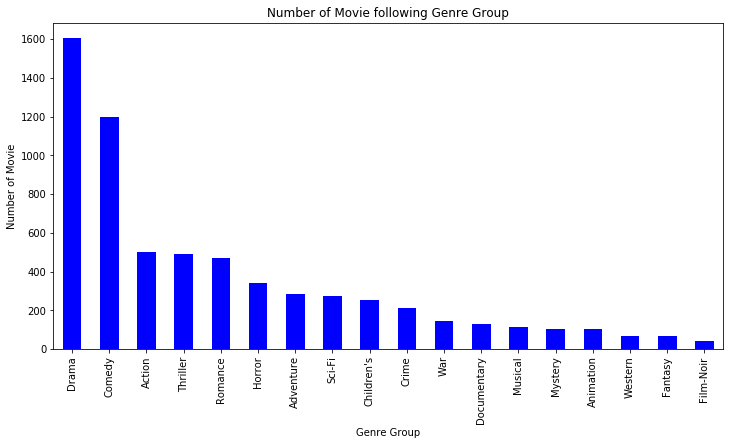

In [30]:
import matplotlib.pyplot as plt
#Visualization genre movie
movie_genre = items.iloc[:,-18:].apply('sum', axis = 0).sort_values(ascending = False)
movie_genre.plot('bar', figsize = (12, 6), color = 'blue')
plt.title('Number of Movie following Genre Group')
plt.xlabel('Genre Group')
plt.ylabel('Number of Movie')
plt.show()

We can see Drama, Comedy are common in MovieLen Page with number of movie is nearly double with next common genre group such as Action, Thriller, Romance. Western, Fantasy and Film-Noir are rare genre.

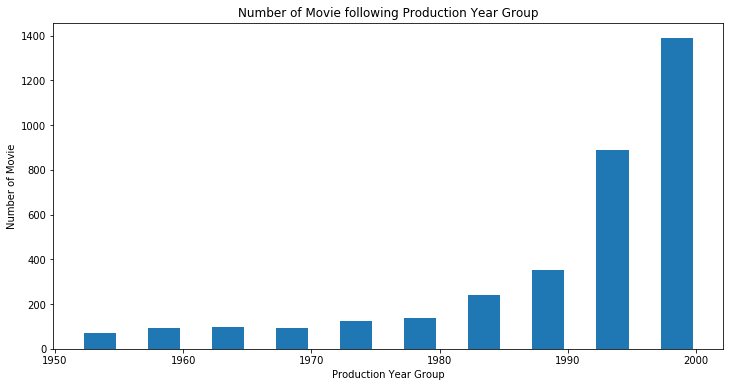

In [74]:
items_year_clean = items.iloc[:,-19:]
items_year_clean = items_year_clean[(items_year_clean['year'] > 1950) & (items_year_clean['year'] < 2005)]
#Visualization production year
production_year = items_year_clean.iloc[:,0]
# production_year[production_year > 10]
f, (ax1) = plt.subplots(1, 1, sharex = True, figsize = (12, 6))
ax1.hist(production_year, bins = 10,  rwidth=0.5)
plt.title('Number of Movie following Production Year Group')
plt.xlabel('Production Year Group')
plt.ylabel('Number of Movie')
plt.show()

Almost Movie is manufactured between 1990 and 2000. It align with the development of Cinema industry in this time.

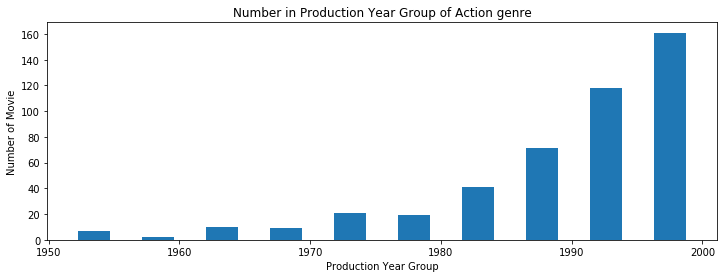

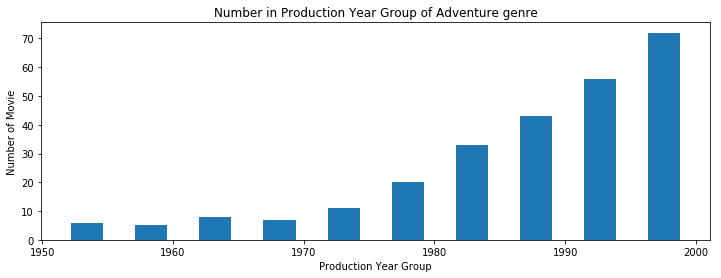

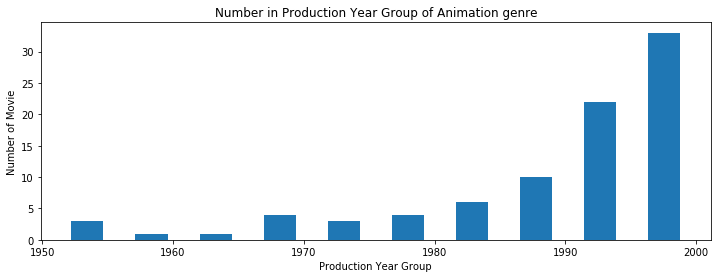

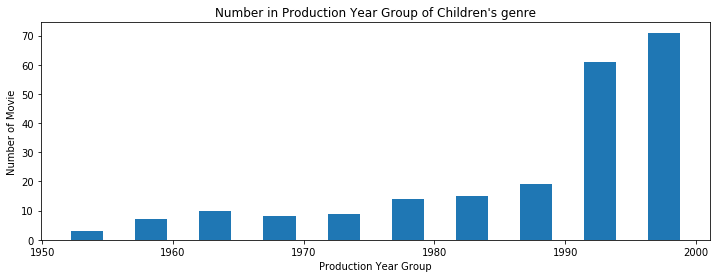

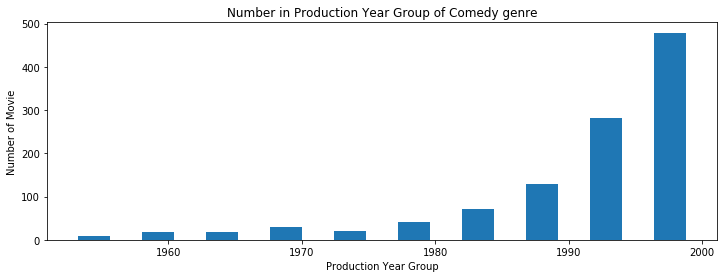

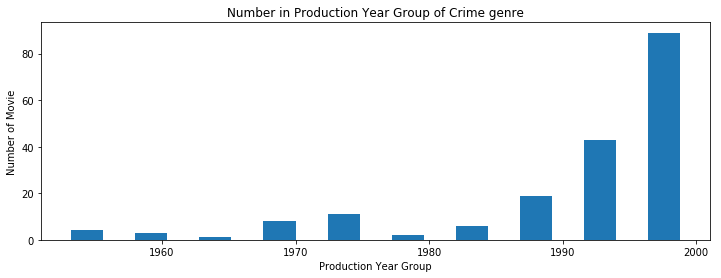

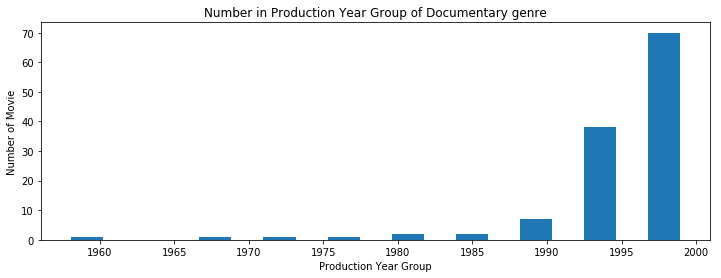

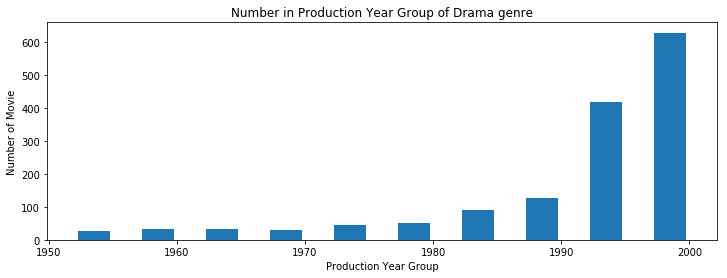

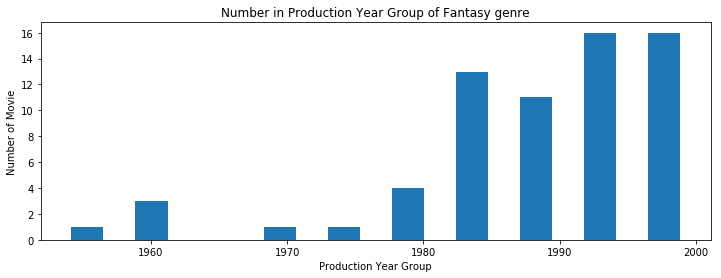

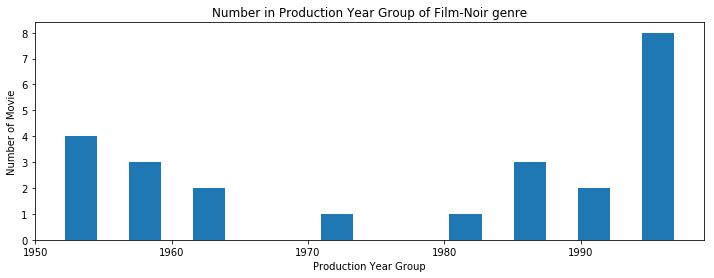

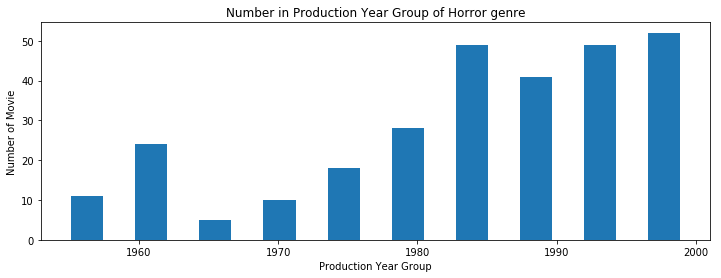

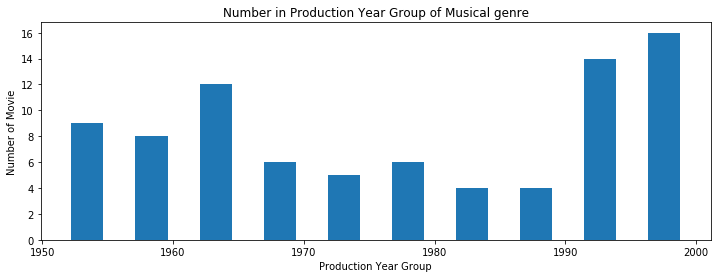

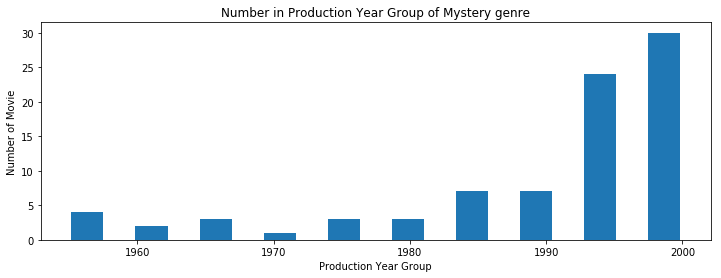

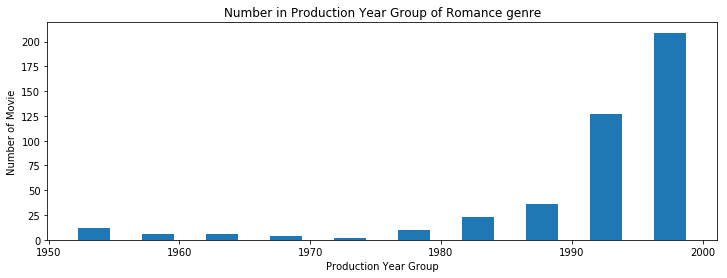

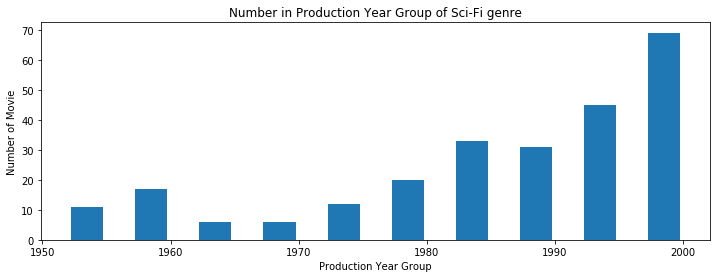

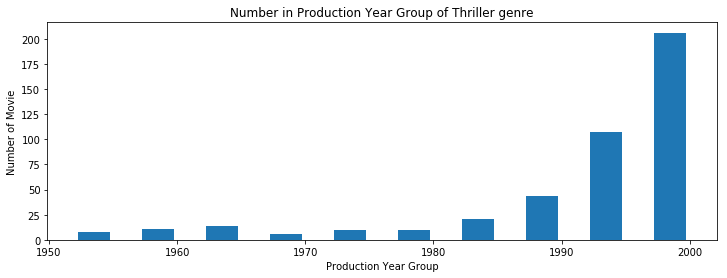

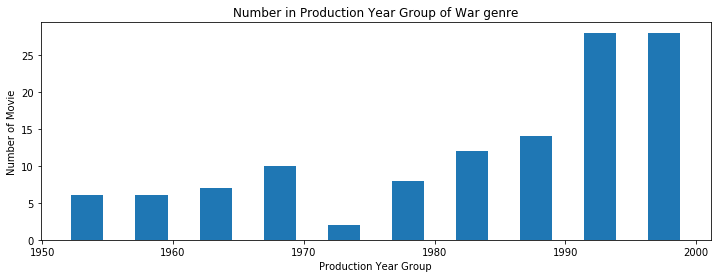

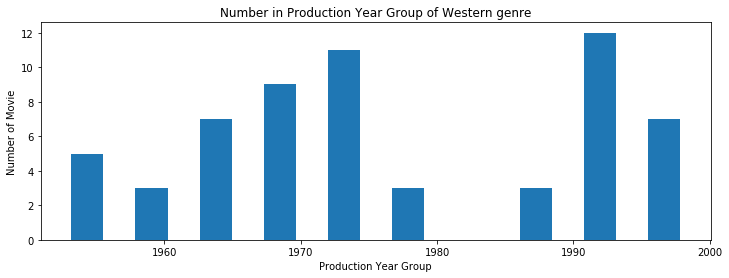

In [84]:
#Visualization production year
genre = items_year_clean.columns.values
for i in range(18):
    action_year = items_year_clean[(items_year_clean.iloc[:,i+1] == 1)]['year']
    # production_year[production_year > 10]
    f, (ax1) = plt.subplots(1, 1, sharex = True, figsize = (12, 4))
    title = 'Number in Production Year Group of ' + genre[i+1] + ' genre'
    ax1.hist(action_year, bins = 10,  rwidth=0.5)
    plt.title(title)
    plt.xlabel('Production Year Group')
    plt.ylabel('Number of Movie')
    plt.show()

The Western, Musical, Fantasy and Film-Noir are genre of last decades and  Action, Comedy, Animation, ... is genre of recent decades.

* Users visualize

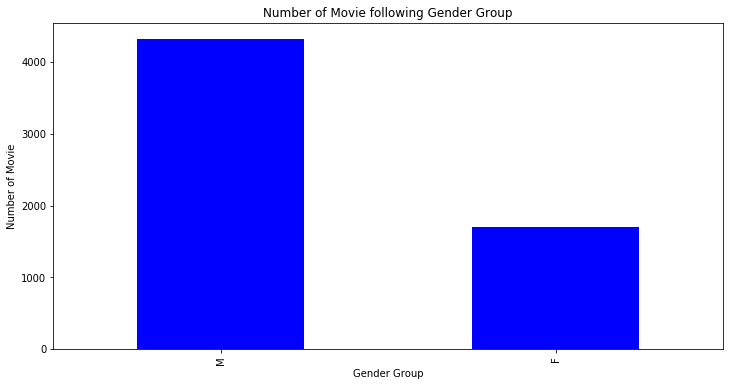

In [97]:
gender = users['sex'].value_counts()
gender.plot('bar', figsize = (12, 6), color = 'blue')
plt.title('Number of Movie following Gender Group')
plt.xlabel('Gender Group')
plt.ylabel('Number of Movie')
plt.show()

The customer gender is unbalanced when Male likely double Female.

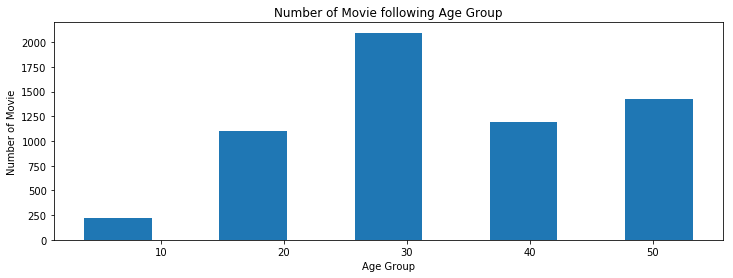

In [100]:
age = users['age']
f, (ax1) = plt.subplots(1, 1, sharex = True, figsize = (12, 4))
ax1.hist(age, bins = 5,  rwidth=0.5)
plt.title('Number of Movie following Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Movie')
plt.show()

The common group is 25-35 and 45-55. Under 10 years old is rare group.

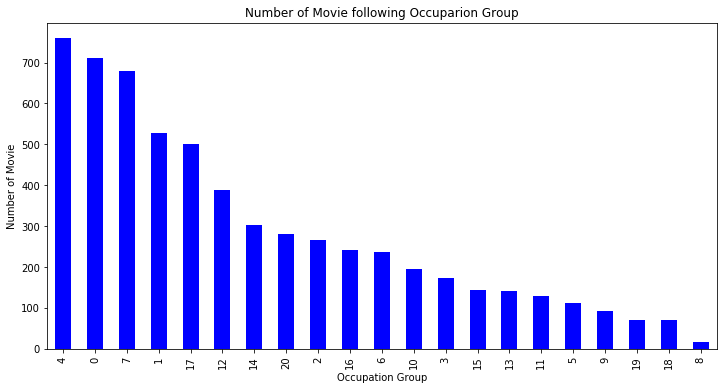

In [101]:
gender = users['occupation'].value_counts()
gender.plot('bar', figsize = (12, 6), color = 'blue')
plt.title('Number of Movie following Occuparion Group')
plt.xlabel('Occupation Group')
plt.ylabel('Number of Movie')
plt.show()

The major occuparion group are 0, 1 , 4, 7, 17 and 5, 9, 19, 18, 8 are rare.

* ratings

In [126]:
movie_avg_rate = ratings.pivot_table(index = ['movie_id'], values=['rating'], aggfunc = np.mean)
movie_avg_rate.columns.name = None
movie_avg_rate = movie_avg_rate.reset_index() 
items_avg_rate = items.merge(movie_avg_rate, on = ['movie_id'], how = 'inner')

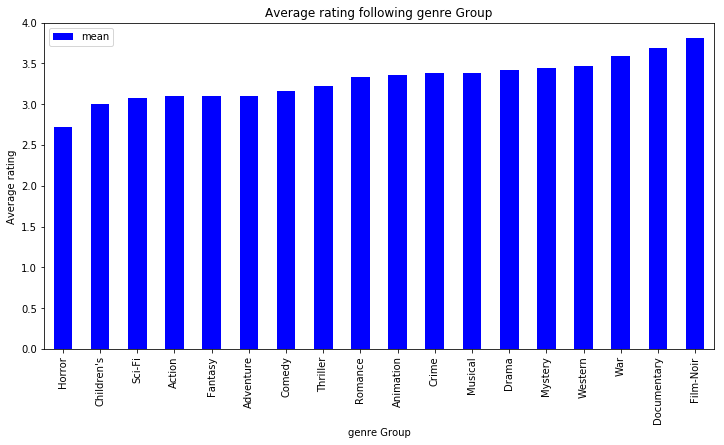

In [174]:
items_rate_clean = items_avg_rate.iloc[:,5:]
items_rate_column = items_rate_clean.iloc[:,:-1].columns.values

mean = []
genre = items_rate_column.tolist()
for i in range(len(items_rate_column)):
    m = items_rate_clean[items_rate_clean.iloc[:, i] == 1].iloc[:, 18].mean()
    mean.append(m)

#create data frame store average rating for each genre movie
genre_avg_rate = pd.DataFrame({'genre': genre, 'mean': mean}).sort_values(by = 'mean')
genre_avg_rate.plot.bar(x = 'genre', y = 'mean', figsize = (12, 6), color = 'blue')
plt.title('Average rating following genre Group')
plt.xlabel('genre Group')
plt.ylabel('Average rating')
plt.show()

The average rating of rare groups like Film-Noir, Documentary, War, Western is greater than common groups. It could be explained that although They are small fans but fans are loyal and more enjoyable than common groups.

Because we are based on `genre` and `production year` to build profiles. So, we only forcus on 19 last columns and create features matrix.

In [111]:
X0 = items.values
X = X0[:, -19:]
X

array([[1995, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [1995, 0.0, 1.0, ..., 0.0, 0.0, 0.0],
       [1995, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [2000, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [2000, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [2000, 0.0, 0.0, ..., 1.0, 0.0, 0.0]], dtype=object)

We can see that `production year` is too big. If we regression on the dataset what exist one feature is extremely bigger than other features then the estimation tendanly focus on this big feature and reduce explaination of the others. Thus we should rescale feature according to formula to make its range in $[0,1]$:
$$x’ = \frac{x - \min(x)}{\max(x) - \min(x)}$$

In [112]:
import warnings
#suppress warning from old version
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
scale_year = min_max_scaler.fit_transform(X[:,0])
X[:,0] = scale_year
X

array([[0.2215801755750639, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.2215801755750639, 0.0, 1.0, ..., 0.0, 0.0, 0.0],
       [0.2215801755750639, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [0.22213579286587398, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.22213579286587398, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.22213579286587398, 0.0, 0.0, ..., 1.0, 0.0, 0.0]], dtype=object)

Next, we will build feature vector for each item based on feature matrix. What we generate at final is [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). This article will don't deeply dig into explaination of TF-IDF. In general, TF-IDF is implemented from word processing, it define how much effectiveness of one Movie to rating result based on its frequency. It is reasonable because one Movie are more frequently rated then it is increasingly well known and rating also tentatively higher.

In [113]:
#tfidf
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=True, norm ='l2')
tfidf = transformer.fit_transform(X.tolist()).toarray()
tfidf

array([[0.03513442, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03066335, 0.        , 0.49957847, ..., 0.        , 0.        ,
        0.        ],
       [0.0584175 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.11725149, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11725149, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0617305 , 0.        , 0.        , ..., 0.85018788, 0.        ,
        0.        ]])

After this step, each row of `tfidf` is a feature vector of each movie. Next we need to find the movie what user rated and its rating through `get_items_rated_by_user()` function.

In [114]:
def get_items_rated_by_user(rate_matrix, user_id):
    """
    in each line of rate_matrix, we have infor: user_id, item_id, rating (scores), time_stamp
    we care about the first three values
    return (item_ids, scores) rated by user user_id
    """
    y = rate_matrix[:,0] # all users
    # item indices rated by user_id
    ids = np.where(y == user_id)[0] 
    item_ids = rate_matrix[ids, 1]
    scores = rate_matrix[ids, 2]
    return (item_ids, scores)

#### Split into train and test

Now, we have already loaded all data include ratings, users and items profile. Next, We need to split data into train and test dataset according to proportion 80:20 (we also can choose other proportion such as 70:30, 50:50, ...). This is very simple by using `train_test_split` from sklearn.

In [92]:
import random
from sklearn.model_selection import train_test_split

random.seed(123)
X_train, X_test = train_test_split(ratings, test_size=0.2)
rate_train = X_train.values
rate_test = X_test.values

#### Regression for each user

Now, with each user we need to make a Ridge Regression. Whole parameters and bias corresponding to each user are saved in parameter matrix $\mathbf{W}$ and vector bias $b$.

In [115]:
from sklearn.linear_model import Ridge
from sklearn import linear_model

d = tfidf.shape[1] # data dimension
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))

for n in range(n_users):    
    items_of_n, scores = get_items_rated_by_user(rate_train, n+1) #plus 1 into user because range(n_users) start from 0
    clf = Ridge(alpha=0.01, fit_intercept  = True)
    ids = [i for i,val in enumerate(items['movie_id']) if val in items_of_n]
    Xhat = tfidf[ids, :]
    
    clf.fit(Xhat, scores) 
    W[:, n] = clf.coef_
    b[0, n] = clf.intercept_

We can easy to know that each column of $\mathbf{W}$ is parameter vector corresponding with one user and each element in this column are parameter of one kind of `production year` and `genre`. Vector $b$ is bias of this linear model. After generating $\mathbf{W}$ and $b$, the forecasted rating matrix $\hat{\mathbf{Y}}$ is calculating as below:

In [116]:
Yhat = tfidf.dot(W) + b

In [117]:
W[1,:]

array([-0.04217507, -0.68300184, -0.19864851, ..., -0.58142549,
        0.43412803,  0.32666803])

Now we can forecast any users we want. For example, all forecast ratings of `user_id` = 10. 

In [118]:
n = 10
np.set_printoptions(precision=2) # 2 digits after . 
items_of_n, scores = get_items_rated_by_user(rate_test, n)
ids = [i for i,val in enumerate(items['movie_id']) if val in items_of_n]
Yhat[n, ids]
print('Rated movies ids :', ids )
print('True ratings     :', scores)
print('Predicted ratings:', Yhat[ids, n])

Rated movies ids : [31, 114, 148, 206, 257, 289, 335, 340, 360, 431, 539, 582, 584, 590, 755, 819, 912, 959, 1009, 1019, 1045, 1063, 1109, 1119, 1178, 1185, 1197, 1205, 1220, 1223, 1236, 1239, 1245, 1251, 1271, 1272, 1274, 1336, 1386, 1533, 1543, 1607, 1656, 1937, 1940, 1952, 1964, 1972, 2008, 2012, 2031, 2046, 2069, 2105, 2124, 2222, 2247, 2255, 2267, 2306, 2327, 2548, 2559, 2588, 2624, 2647, 2726, 2789, 2965, 2997, 3039, 3106, 3129, 3227, 3339, 3370, 3378, 3382, 3599, 3602, 3619, 3632]
True ratings     : [5 4 5 5 4 3 5 4 4 4 5 4 3 3 5 4 5 5 5 4 3 2 3 5 4 3 4 5 5 4 5 3 5 5 5 5 3
 5 4 5 5 4 5 4 5 4 3 5 4 5 5 3 3 3 3 4 3 5 5 4 5 4 5 4 3 3 4 5 5 5 5 4 4 5
 5 5 4 4 4 3 2 5]
Predicted ratings: [2.59 2.5  2.85 3.41 3.49 3.34 3.11 3.41 1.26 2.66 3.14 2.3  1.29 1.26
 3.14 3.41 1.95 3.3  1.26 1.26 3.04 3.41 3.4  3.4  3.08 2.85 3.11 1.36
 2.95 3.14 3.56 3.12 3.11 3.31 3.41 3.4  3.56 3.04 3.11 2.95 2.59 2.72
 3.31 3.24 2.81 3.52 0.95 2.63 2.48 1.34 3.77 3.41 1.95 3.99 3.92 3.04
 3.04 3.14 3.31 3

#### Evaluate model

To evaluate model we will use Root Mean Squared Error [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) for rating. Error is equal to deviation between `true rating` and `predicted rating`

In [119]:
from math import sqrt
def evaluate(Yhat, rates, W, b):
    se = 0
    cnt = 0
    for n in range(n_users):
        items_of_n, scores_truth = get_items_rated_by_user(rates, n)
        ids = [i for i,val in enumerate(items['movie_id']) if val in items_of_n]
        scores_pred = Yhat[ids, n]
        e = scores_truth - scores_pred 
        se += (e*e).sum(axis = 0)
        cnt += e.size 
    return sqrt(se/cnt)

print ('RMSE for test    :', evaluate(Yhat, rate_test, W, b))

RMSE for test    : 1.4634875893734853


Because of train and test dataset are change in each time we run model so `RMSE` you running could be different from this article result. To fixed results you just need 

`import random` 

`random.seed(any_number)`

Error is 1.46 rating is a weak result in this problem. We should check a new method to see if the `RMSE` can be reduced.

## 3. Collaborative filtering

As we known, Content-Based System forecast rating only use information of each item, which shown in feature matrix without using any user information. In constrast with Content-Based System, Collaborative-Filtering forecast the rating of one user for one item by using the rating of other users who are similar watching enjoyment. The similarity can be defined on the rating for the items. For example, we known that A,B like `Bed of Roses` (Romantic genre) and both of them rate for this movie 5 rate point and we also known A like `Honeymoon in Vegas` so we can suspect that likely B also like this movie. We will figure out the foundation of this alogrithm when response two question:

* How do we define the similarity between two different users?
* When we known similarity, how could we forecast interesting level of one user into one item?

Moreover, there are two approaches for Collaborative-Filtering. The first, defining interesting level of one user on one item based on similar users, which called as `User-User collaborative filtering`. The second, based on the similar items with the high rating items to suppose them for user, which called as `Item-item collaborative filtering`. We will go through both of them.

### 3.1 User-user Collaborative Filtering

#### Similarity function

The best prior importance we should do is defining the similarity between two users. It only is infered from Utility Matrix $\mathbf{Y}$ and we measure similarity on the columns of this matrix. 

<br/>
<img src=".\utility.png" alt="Utility Matrix" width="200px"/>
<p align='center' style="text-align:center">Picture1: Utility Matrix</p>
<br/>

We have example about utility matrix with each row is the ratings of each item from all users and each column is the whole ratings of each user. The grey with question mark represent to movie have not rated yet. At the first sight we figure out that $u_0$ is more similar to $u_1$ than $u_2, u_3, u_4, u_5, u_6$. One similarity function is conservative must sastify:
$$\text{sim}(u_0, u_1) > \text{sim}(u_0, u_i), ~\forall i > 1.$$
In natural way, the function we chose is correlation. But one user only fill a small part of items set. This make our matrix is missing a lot and the correlation don't response exactly relationship between two user behavior. How do we deal with that? simply, we need to fill in matrix in the missing points. But what value should be filled in are most reasonable? Let's analysis in three scenarios:

* Fill up the smallest rating, it mean 0: This way makes sense with severe users who tend to rating low point but with easy users it isn't judicially. Actually, we will get bias with this group users.
* Fill up the biggest rating, it mean 5: completely same with above. We aren't equal with severe group users.
* The final, we fill up with mean: It is most conservative because we don't high rate with servere group users and also low rate with easy group users.

<br/>
<br/>
<img src=".\user_cf.png" alt="Process of User-User Collaborative Filtering"/>
<p align='center' style="text-align:center">Picture2: Process of User-User Collaborative Filtering</p>

**Standardize data**

Before we fill up Utility Matrix, we see that each user will have different mean of rating. The severe users maybe lower rating's mean than the easy users while our model don't care about what kind of user belong to. Hence, we need to standardize data to make servere users and easy users are equal. The simplest way is make their expectation rating become 0. This also benefit to storage when almost values in Utility Matrix are missing. After standardizing data, the means are 0 and we store Utility Matrix with almost 0 values. `Sparse Matrix` are useful to be used in this case (only store value different 0 and its position).

**Cosine Similarity**

Correlation also called as Cosine Similarity because its formula is similar with $cos$ between two vector $u_1, u_2$ and shown as below:
$$\text{cosine_similarity}(\mathbf{u}_1, \mathbf{u}_2) =\text{cos}(\mathbf{u}_1, \mathbf{u}_2) 
=  \frac{\mathbf{u}_1^T\mathbf{u}_2}{ ||\mathbf{u}_1||_2.||\mathbf{u}_2||_2}~~~~ (1)$$

And very simple we all known:

* consine similarity is between $[-1,1]$
* when it is near 1, the similarity between two users are more high.
* when it is near -1, the similarity between two users are in contrast.
* when it is near 0, two users do not have much relationship. In other ways, they are not similar.

**Rating prediction**

After finding $K$ users are most similar, we need to estimate the rating of one item based on what $K$ users rated. The predicted rating usually calculate from weighted average of the standardized ratings. Each weighted is consine similarity with user we are forecasting to. For example the rating of user $u$ for $i$ is estimated:

$$\hat{y}_{i, u} = \frac{\sum_{u_j \in \mathcal{N}(u, i)} \bar{y}_{i, u_j} \text{sim}(u, u_j)}{\sum_{u_j \in \mathcal{N}(u, i)} |\text{sim}(u, u_j)|} ~~~~ (2)$$

in which, $\mathcal{N}(u,i)$ is group of $K$ most similar user with u who have **already rated** i.

### 3.2 Items-items Collaborative Filtering

Items-items Collaborative Filtering absolutely similar with Users-users Collaborative Filtering about processing. What we should do for it when we have already built the processing code for Users-users Collaborative Filtering is transpose Utility Matrix $\mathbf{Y}$. But it is in term of processing. Actually Items-items Collaborative Filtering is different meaning of User-user Collaborative Filtering at below sides:

* We forecus on finding the items are similar with the highest rated items of one user to suggest him. Meanwhile User-user Collaborative Filtering based on similarity between the user pairs to forecast rating.

* Actually, number of users is usually higher than items. Thus similarity matrix is small dimension than User-user Collaborative Filtering. It support to calculation alot in the following processes.

In this article we will build function for both of this two methods through declare argument which decides if we transpose $\mathbf{Y}$ matrix.

### 3.3 Construct alogrithm

We build alogrithm following the way we describe above. To compare result with Content-Based Recommendation alogrithm, we use the same `rate_train` and `rate_test` with before model in chapter **2.2**.

In [311]:
print("Dimension of rate_train: ", rate_train.shape)
print("Dimension of rate_test: ", rate_test.shape)

Dimension of rate_train:  (800167, 4)
Dimension of rate_test:  (200042, 4)


To be more neat and easy to implement, we will initalize class CF for this alogrithms. All function for predicting, recommending or checking error are combined in this class. To create a complete class `CF`, you have to firstly run below code without totally understanding about its meaning. I will explain to each function in following code.

In [103]:
import numpy as np
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

class CF(object):
    #init function 
    def __init__(self, Y_data, K, dist_func = cosine_similarity, uuCF = 1):
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]] #if item-item CF then only change column 1 to 0
        self.K = K # number of neighbor points
        self.dist_func = dist_func
        self.Ybar_data = None
        self.Ybar = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = None
        self.n_items = None
        #create vector store mean rating of the movies what user rated.
        self.mu = None
        
    def normalize_Y(self):
        #take all users is first column of Y_data
        all_users = self.Y_data[:, 0]
        self.Ybar_data = self.Y_data.copy()
        #take users unique list
        users_list = np.unique(self.Y_data[:, 0])
        #take dimension of users and items in sparse matrix. Because index start from 0 so we need to plus 1.
        self.n_users = int(max(self.Y_data[:,0])+1)
        self.n_items = int(max(self.Y_data[:,1])+1)
        #create vector which store mean ratings of user u.
        self.mu = np.zeros(self.n_users)
        for u in users_list:
            #find all rating ids which user = u rated
            ids = np.where(all_users == u)
            ratings_of_u = self.Y_data[ids, 2]
            #take mean of rating
            m = np.mean(ratings_of_u)
            self.mu[u] = m
            if np.isnan(m):
                m = 0 #to avoid empty array and nan value
            #standardize data
            self.Ybar_data[ids, 2] = ratings_of_u - m
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
                    (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr()
    
    def similarity(self):   
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)
        
    def fit(self):
        self.normalize_Y()
        self.similarity()
        
    def __pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)  
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        # Step 2: find similarity btw the current user and others 
        # who already rated i
        sim = self.S[u, users_rated_i]
        # Step 3: find the k most similarity users
        a = np.argsort(sim)[-self.K:] 
        # and the corresponding similarity levels
        nearest_s = sim[a]
        # How did each of 'near' users rated item i
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            # add a small number, for instance, 1e-8, to avoid dividing by 0
            return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]

    def pred(self, u, i, normalized = 1):
        if self.uuCF:
            return self.__pred(u, i, normalized)
        return self.__pred(i, u, normalized)
    
    def recommend(self, u, normalized = 1):
        """
        Determine all items should be recommended for user u. (uuCF =1)
        or all users who might have interest on item u (uuCF = 0)
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which 
        have not been rated by u yet. 
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist() 
        #take users unique list
        items_list = np.unique(self.Y_data[:, 1])
        recommended_items = []

        for i in items_list:
            if i not in items_rated_by_u:
                rating = self.pred(u, i, self.uuCF)
                if rating > 0: 
                    recommended_items.append([i, rating])
        
        if len(recommended_items) == 0: return []
        recommended_items = np.array(recommended_items, dtype = 'f')
        a = np.argsort(recommended_items[:,1])[::-1]
        recommended_items = recommended_items[a, 0].astype(int).tolist()
        return recommended_items

    def print_recommendation(self, top, u):
        """
        print all items which should be recommended for each user 
        """
        print ('Recommendation: ')
        recommended_items = self.recommend(u)[:top]
        if self.uuCF:
            print ('Top ', top, ' recommend item(s):', recommended_items, 'to user', u)
        else: 
            print ('Top ', top, ' recommend item', u, 'to user(s) : ', recommended_items)

Actually class CF include three part: **initialize, fit and recommend**.

**Initialize class CF**

Initialize a CF class enable to us use every its functions (in programing we also call methods) and arguments.

In [319]:
import numpy as np
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

class CF(object):
    #init function 
    def __init__(self, Y_data, K, dist_func = cosine_similarity, uuCF = 1):
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]] #if item-item CF then only change column 1 to 0
        self.K = K # number of neighbor points
        self.dist_func = dist_func
        self.Ybar_data = None
        self.Ybar = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = None
        self.n_items = None
        #create vector store mean rating of the movies what user rated.
        self.mu = None

**Fit model**

Fit model include two part are normalize Utility Matrix and calculate Similarity Matrix. In normalize Utility Matrix step, we transform $\mathbf{Y}$ so each user rating are subtracted to its mean of the rating values which user rated. The Utility Matrix should be stored as [sparse matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) to save the memory and calculation time. 

In [318]:
def normalize_Y(self):
    #take all users is first column of Y_data
    all_users = self.Y_data[:, 0]
    self.Ybar_data = self.Y_data.copy()
    #take users unique list
    users_list = np.unique(self.Y_data[:, 0])
    #take dimension of users and items in sparse matrix. Because index start from 0 so we need to plus 1.
    self.n_users = int(max(self.Y_data[:,0])+1)
    self.n_items = int(max(self.Y_data[:,1])+1)
    #create vector which store mean ratings of user u.
    self.mu = np.zeros(self.n_users)
    for u in users_list:
        #find all rating ids which user = u rated
        ids = np.where(all_users == u)
        ratings_of_u = self.Y_data[ids, 2]
        #take mean of rating
        m = np.mean(ratings_of_u)
        self.mu[u] = m
        if np.isnan(m):
            m = 0 #to avoid empty array and nan value
        #standardize data
        self.Ybar_data[ids, 2] = ratings_of_u - m
    self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
                (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
    self.Ybar = self.Ybar.tocsr()

Now, each Ybar's column is the whole ratings of each user and each row is the whole ratings of each movie (rating are standardized). We easy to calculate Similarity matrix as below:

In [315]:
def similarity(self):   
    self.S = self.dist_func(self.Ybar.T, self.Ybar.T)

Create function fit() to activate normalize_Y() and similarity() each time we run model.

In [ ]:
def fit(self):
    self.normalize_Y()
    self.similarity()

**Recommend**

Create prediction function rating values for each user. This function predict rating of user u for item i (standardized) based on K most similar users.

In [316]:
def __pred(self, u, i, normalized = 1):
    """ 
    predict the rating of user u for item i (normalized)
    if you need the un
    """
    # Step 1: find all users who rated i
    ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)  
    users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
    # Step 2: find similarity btw the current user and others 
    # who already rated i
    sim = self.S[u, users_rated_i]
    # Step 3: find the k most similarity users
    a = np.argsort(sim)[-self.K:] 
    # and the corresponding similarity levels
    nearest_s = sim[a]
    # How did each of 'near' users rated item i
    r = self.Ybar[i, users_rated_i[a]]
    if normalized:
        # add a small number, for instance, 1e-8, to avoid dividing by 0
        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

    return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    
def pred(self, u, i, normalized = 1):
    if self.uuCF:
        return self.__pred(u, i, normalized)
    return self.__pred(i, u, normalized)

With each user, we will use `pred()` function to forecast its normalized ratings on the movie user have not seen yet (we should note that ratings have been normalized). We filter all forecast normalized ratings > 0 to recommend customer. The priority based on forecast normalized ratings are big or small. `recommend()` function to find the movie and `print_recommendation()` to print out recommendation results.

In [331]:
def recommend(self, u, normalized = 1):
    """
    Determine all items should be recommended for user u. (uuCF =1)
    or all users who might have interest on item u (uuCF = 0)
    The decision is made based on all i such that:
    self.pred(u, i) > 0. Suppose we are considering items which 
    have not been rated by u yet. 
    """
    ids = np.where(self.Y_data[:, 0] == u)[0]
    items_rated_by_u = self.Y_data[ids, 1].tolist() 
    #take users unique list
    items_list = np.unique(self.Y_data[:, 1])
    recommended_items = []
    
    for i in items_list:
        if i not in items_rated_by_u:
            rating = self.pred(u, i, self.uuCF)
            if rating > 0: 
                recommended_items.append([i, rating])
                
    if len(recommended_items) == 0: return []
    recommended_items = np.array(recommended_items, dtype = 'f')
    a = np.argsort(recommended_items[:,1])[::-1]
    recommended_items = recommended_items[a, 0].astype(int).tolist()
    return recommended_items

def print_recommendation(self, top, u):
    """
    print all items which should be recommended for each user 
    """
    print ('Recommendation: ')
    recommended_items = self.recommend(u)[:top]
    if self.uuCF:
        print ('Top ', top, ' recommend item(s):', recommended_items, 'to user', u)
    else: 
        print ('Top ', top, ' recommend item', u, 'to user(s) : ', recommended_items)

Test function for user 1 forecast movie 1 based on 10 most similarity.

In [104]:
rs = CF(rate_train, K = 2, uuCF = 1)
rs.fit()
rs.print_recommendation(u = 1, top = 10)

Recommendation: 
Top  10  recommend item(s): [138, 1886, 1430, 641, 823, 3460, 1773, 2661, 231, 663] to user 1


**Evaluate model**

Now is the best important part, We will check the error between forecast and actual rating to compare Collaborative Filtering with Content-Based Alogrithms accuracy.

**User-user CF:**

In [13]:
from math import sqrt
SE = 0 # squared error
users_id_test = np.unique(rate_test[:,0])
for n in users_id_test:
    pred = rs.pred(rate_test[n, 0], rate_test[n, 1], normalized = 0)
    SE += (pred - rate_test[n, 2])**2 
    n_users = len(users_id_test)
RMSE = np.sqrt(SE/n_users)
print('User-user CF, RMSE =', RMSE)

User-user CF, RMSE = 0.9937568432929201


**Item-item CF:**

In [105]:
rs = CF(rate_train, K = 2, uuCF = 0)
rs.fit()

SE = 0 # squared error
items_id_test = np.unique(rate_test[:,0])
for n in items_id_test:
    pred = rs.pred(rate_test[n, 0], rate_test[n, 1], normalized = 0)
    SE += (pred - rate_test[n, 2])**2 
    n_items = len(items_id_test)
RMSE = np.sqrt(SE/n_items)
print('Item-item CF, RMSE =', RMSE)

Item-item CF, RMSE = 0.9616167529623764


As we can see, compare with Content-Based Recommendation (error = 1.46) this result is improved a lot. We also tuning model by change K nearest similarity to reduce RMSE. Because of computer's graphic restriction, i will not process tuning.